# Entrainement du modèle

Dans ce notebook, nous allons entrainer notre modèle afin qu'il puisse classifier les positions capturées avec la caméra dans les classes ``correct`` ou ``non correcte``. Le modèle que nous allons utiliser est dérivé du modèle MoveNet.

Nous allons utiliser la librairie Keras / Tensorflow pour créer notre modèle.

In [2]:
import tensorflow as tf
import numpy as np
import cv2
import os
import shutil
from tqdm import tqdm

from tensorflow import keras
from matplotlib import pyplot as plt

### Téléchargement et extraction des données collectées 

Tout d'abord il faut récupérer les données collectées contenues dans le fichier ``dataset.zip`` que nous avons créé précedemment. Pour cela, il suffit d'exécuter la commande ci-dessous.

In [3]:
#!unzip -q dataset.zip

Un dossier nommé ``dataset`` devrait apparaître dans l'explorateur de fichiers.

# Création des datasets

### Chargement des images dans le dataset d'entrainement

A partir des images sauvegardées dans le répertoire de travail, on peut maintenant créer notre dataset. On commence par créer une liste contenant les deux classes utilisées :

In [4]:
nom_position = "Corbeau"

CATEGORIES = ['correct', 'non_correct']
datasets = {}
for name in CATEGORIES:
    datasets[name] = []

On charge ensuite les données à l'aide de la fonction ``image_dataset_from_directory`` de Keras, en précisant la résolution des images et le type de label associé (ici on utilise le type ``categorical`` - voir ci-dessous). On demande également d'utiliser un ``batch size`` de 1 et d'utiliser 90% des images pour l'entrainement et les 10% restant pour les validations :

In [5]:
# Récupère le répertoire courant
repertoire_courant = os.getcwd()

# Création du dataset d'entrainement
dataset_entrainement = tf.keras.preprocessing.image_dataset_from_directory(
    repertoire_courant + "/dataset/" + nom_position + "/",
    validation_split=0.2,
    subset="training",
    image_size=(256, 256),
    batch_size=1,
    shuffle=True,
    seed=123,
    label_mode='categorical')

# Création du dataset de validation
dataset_validation = tf.keras.preprocessing.image_dataset_from_directory(
    repertoire_courant + "/dataset/" + nom_position + "/",
    validation_split=0.2,
    subset="validation",
    image_size=(256, 256),
    batch_size=1,
    shuffle=True,
    seed=123,
    label_mode='categorical')

Found 61 files belonging to 2 classes.
Using 49 files for training.
Found 61 files belonging to 2 classes.
Using 12 files for validation.


In [6]:
# Extraciton des tenseurs depuis le dataset
images_entrainement, labels_entrainement = tuple(zip(*dataset_entrainement))
images_validation, labels_validation = tuple(zip(*dataset_validation))

Observons le nom des classes utilisées :

In [7]:
class_names = dataset_entrainement.class_names
print(class_names)

['CORRECT', 'NON_CORRECT']


Regardons le format du tenseur contenu dans le dataset :

In [8]:
for image,label in dataset_entrainement.take(2):
    print(image.shape)
    print(label.shape)

(1, 256, 256, 3)
(1, 2)
(1, 256, 256, 3)
(1, 2)


Affichons quelques labels codé de manière "categorical" et leur valeur équivalente "binaire" :

In [9]:
for image,label in dataset_entrainement.take(5):
    print("Label categorical : %s" %label[0])
    print("Label binaire correspondant : %s" %np.argmax(label[0], axis=None, out=None))
    print("Classe correspondante : %s" %class_names[np.argmax(label[0], axis=None, out=None)])
    print("")

Label categorical : tf.Tensor([0. 1.], shape=(2,), dtype=float32)
Label binaire correspondant : 1
Classe correspondante : NON_CORRECT

Label categorical : tf.Tensor([0. 1.], shape=(2,), dtype=float32)
Label binaire correspondant : 1
Classe correspondante : NON_CORRECT

Label categorical : tf.Tensor([0. 1.], shape=(2,), dtype=float32)
Label binaire correspondant : 1
Classe correspondante : NON_CORRECT

Label categorical : tf.Tensor([0. 1.], shape=(2,), dtype=float32)
Label binaire correspondant : 1
Classe correspondante : NON_CORRECT

Label categorical : tf.Tensor([0. 1.], shape=(2,), dtype=float32)
Label binaire correspondant : 1
Classe correspondante : NON_CORRECT



Affichons maintenant quelques images :

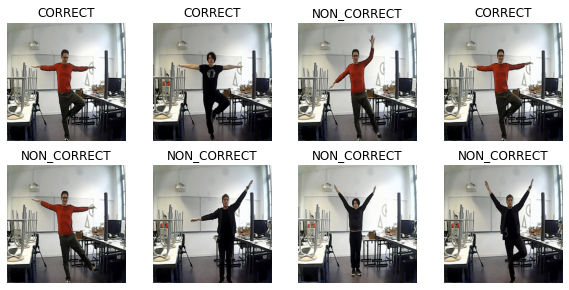

In [10]:
plt.figure(figsize=(10, 10))

for i in range(8):
    index = np.random.randint(0,len(dataset_entrainement))
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images_entrainement[index][0].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels_entrainement[index][0], axis=None, out=None)])
    plt.axis("off")

On va maintenant utiliser le modèle MoveNet pour créer les données d'entrées pour l'entrainement

In [11]:
import tensorrt as trt
import pycuda.driver as cuda
import pycuda.autoinit

PRECISION = trt.int32

# Construction de la class du logger
class MyLogger(trt.ILogger):
    def __init__(self):
        trt.ILogger.__init__(self)

    def log(self, severity, msg):
        print("%s : %s" %(severity,msg))
        pass

logger = MyLogger()
runtime = trt.Runtime(logger)

with open("model_jetson.engine", "rb") as f:
    engine = runtime.deserialize_cuda_engine(f.read())

context = engine.create_execution_context()

# Réservation de la mémoire pour l'entrée
size_input = trt.volume(engine.get_binding_shape(0))* engine.max_batch_size
input_host_mem = cuda.pagelocked_empty(size_input, trt.nptype(PRECISION))
input_device_mem = cuda.mem_alloc(input_host_mem.nbytes)

# Réservation de la mémoire pour les sorties
output_device_mem = [];
format_sorties = [];
types_sorties = [];

for i in range(engine.num_bindings):
    if not engine.binding_is_input(i):
        size_output = trt.volume(engine.get_binding_shape(i))* engine.max_batch_size
        output_host_mem = cuda.pagelocked_empty(size_output, trt.nptype(PRECISION))
        output_device_mem.append(cuda.mem_alloc(output_host_mem.nbytes))
        format_sorties.append(engine.get_binding_shape(i))
        types_sorties.append(trt.nptype(engine.get_binding_dtype(i)))

# Récupère les adresses en GPU des buffers entrées / sorties
binding_entree = int(input_device_mem)

binding_sorties = []
for output_ in output_device_mem:
    binding_sorties.append(int(output_))

# Initialise le moteur
print("Initialisation du moteur..")
x = images_entrainement[0].numpy().astype(np.int32)
np.copyto(input_host_mem,x.ravel())
cuda.memcpy_htod(input_device_mem, input_host_mem)
bindings = [binding_entree, binding_sorties[0]]
context.execute_v2(bindings=bindings)

Severity.INFO : [MemUsageChange] Init CUDA: CPU +224, GPU +1, now: CPU 878, GPU 3456 (MiB)
Severity.INFO : Loaded engine size: 16 MiB
Severity.VERBOSE : Using cublas as a tactic source
Severity.INFO : [MemUsageChange] Init cuBLAS/cuBLASLt: CPU +158, GPU +8, now: CPU 1055, GPU 3461 (MiB)
Severity.VERBOSE : Using cuDNN as a tactic source
Severity.INFO : [MemUsageChange] Init cuDNN: CPU +241, GPU -9, now: CPU 1296, GPU 3452 (MiB)
Severity.VERBOSE : Deserialization required 13718782 microseconds.
Severity.INFO : [MemUsageChange] TensorRT-managed allocation in engine deserialization: CPU +0, GPU +14, now: CPU 0, GPU 14 (MiB)
Severity.VERBOSE : Using cublas as a tactic source
Severity.INFO : [MemUsageChange] Init cuBLAS/cuBLASLt: CPU +0, GPU +0, now: CPU 1279, GPU 3445 (MiB)
Severity.VERBOSE : Using cuDNN as a tactic source
Severity.INFO : [MemUsageChange] Init cuDNN: CPU +0, GPU +1, now: CPU 1279, GPU 3446 (MiB)
Severity.VERBOSE : Total per-runner device persistent memory is 13678592
Severi

True

In [12]:
predictions_entrainement = []
predictions_validation = []

for i in tqdm(range(len(dataset_entrainement))):
    x = images_entrainement[i].numpy().astype(np.int32)
    np.copyto(input_host_mem,x.ravel())
    cuda.memcpy_htod(input_device_mem, input_host_mem)
    bindings = [binding_entree, binding_sorties[0]]
    context.execute_v2(bindings=bindings)
    output_host_mem = np.zeros(format_sorties[0],types_sorties[0])
    cuda.memcpy_dtoh(output_host_mem[0], output_device_mem[0])
    predictions_entrainement.append(output_host_mem[0][0])

for i in tqdm(range(len(dataset_validation))):
    x = images_validation[i].numpy().astype(np.int32)
    np.copyto(input_host_mem,x.ravel())
    cuda.memcpy_htod(input_device_mem, input_host_mem)
    bindings = [binding_entree, binding_sorties[0]]
    context.execute_v2(bindings=bindings)
    output_host_mem = np.zeros(format_sorties[0],types_sorties[0])
    cuda.memcpy_dtoh(output_host_mem[0], output_device_mem[0])
    predictions_validation.append(output_host_mem[0][0])

100%|██████████| 12/12 [00:00<00:00, 25.19it/s]


# Vérification des positions

In [13]:
import cv2

def draw_lines(img_cv2, coordonneesXY, line_width=1):
    width, height = (256,256)

    nez = [int(coordonneesXY[0][1]*width),int(coordonneesXY[0][0]*height)]
    oeuil_gauche = [int(coordonneesXY[1][1]*width),int(coordonneesXY[1][0]*height)]
    oeuil_droit = [int(coordonneesXY[2][1]*width),int(coordonneesXY[2][0]*height)]
    oreille_gauche = [int(coordonneesXY[3][1]*width),int(coordonneesXY[3][0]*height)]
    oreille_droite = [int(coordonneesXY[4][1]*width),int(coordonneesXY[4][0]*height)]
    epaule_gauche = [int(coordonneesXY[5][1]*width),int(coordonneesXY[5][0]*height)]
    epaule_droite = [int(coordonneesXY[6][1]*width),int(coordonneesXY[6][0]*height)]
    coude_gauche = [int(coordonneesXY[7][1]*width),int(coordonneesXY[7][0]*height)]
    coude_droite = [int(coordonneesXY[8][1]*width),int(coordonneesXY[8][0]*height)]
    poignet_gauche = [int(coordonneesXY[9][1]*width),int(coordonneesXY[9][0]*height)]
    poignet_droite = [int(coordonneesXY[10][1]*width),int(coordonneesXY[10][0]*height)]
    hanche_gauche = [int(coordonneesXY[11][1]*width),int(coordonneesXY[11][0]*height)]
    hanche_droite = [int(coordonneesXY[12][1]*width),int(coordonneesXY[12][0]*height)]
    genou_gauche = [int(coordonneesXY[13][1]*width),int(coordonneesXY[13][0]*height)]
    genou_droite = [int(coordonneesXY[14][1]*width),int(coordonneesXY[14][0]*height)]
    cheville_gauche = [int(coordonneesXY[15][1]*width),int(coordonneesXY[15][0]*height)]
    cheville_droite = [int(coordonneesXY[16][1]*width),int(coordonneesXY[16][0]*height)]


    centre_yeux = [((int(0.5*(coordonneesXY[1][1]*width+int(coordonneesXY[2][1]*width))))),((int(0.5*(coordonneesXY[1][0]*height+int(coordonneesXY[2][0]*height)))))]
    centre_epaules = [((int(0.5*(coordonneesXY[5][1]*width+int(coordonneesXY[6][1]*width))))),((int(0.5*(coordonneesXY[5][0]*height+int(coordonneesXY[6][0]*height)))))]
    centre_hanches =  [((int(0.5*(coordonneesXY[11][1]*width+int(coordonneesXY[12][1]*width))))),((int(0.5*(coordonneesXY[11][0]*height+int(coordonneesXY[12][0]*height)))))]


    # Lignes nez-centre des yeux
    img = cv2.line(img_cv2, (nez[0],nez[1]),(centre_yeux[0],centre_yeux[1]),color=(0, 0, 255), thickness=2)

    # Lignes centre des yeux - oueil gauche
    img = cv2.line(img_cv2, (oeuil_gauche[0],oeuil_gauche[1]),(centre_yeux[0],centre_yeux[1]),color=(0, 0, 255), thickness=2)

    # Lignes centre des yeux - oueil droit
    img = cv2.line(img_cv2, (oeuil_droit[0],oeuil_droit[1]),(centre_yeux[0],centre_yeux[1]),color=(0, 0, 255), thickness=2)

    # Lignes oeuil_gauche - oreille gauche
    img = cv2.line(img_cv2, (oeuil_gauche[0],oeuil_gauche[1]),(oreille_gauche[0],oreille_gauche[1]),color=(0, 0, 255), thickness=2)

    # Lignes oeuil_droit - oreille droite
    img = cv2.line(img_cv2, (oeuil_droit[0],oeuil_droit[1]),(oreille_droite[0],oreille_droite[1]),color=(0, 0, 255), thickness=2)

    # Lignes nez-centre_epaules
    img = cv2.line(img_cv2, (nez[0],nez[1]),(centre_epaules[0],centre_epaules[1]),color=(0, 0, 255), thickness=2)

    # Ligne centre_epaules - epaule_droit
    img = cv2.line(img_cv2, (epaule_droite[0],epaule_droite[1]),(centre_epaules[0],centre_epaules[1]),color=(0, 0, 255), thickness=2)

    # Ligne centre_epaules - epaule_gauche
    img = cv2.line(img_cv2, (epaule_gauche[0],epaule_gauche[1]),(centre_epaules[0],centre_epaules[1]),color=(0, 0, 255), thickness=2)

    # Ligne épaule_gauche - coude_gouche
    img = cv2.line(img_cv2, (epaule_gauche[0],epaule_gauche[1]),(coude_gauche[0],coude_gauche[1]),color=(0, 0, 255), thickness=2)

    # Ligne coude_gouche - poignet_gauche
    img = cv2.line(img_cv2, (poignet_gauche[0],poignet_gauche[1]),(coude_gauche[0],coude_gauche[1]),color=(0, 0, 255), thickness=2)

    # Ligne épaule_droite - coude_doit
    img = cv2.line(img_cv2, (epaule_droite[0],epaule_droite[1]),(coude_droite[0],coude_droite[1]),color=(0, 0, 255), thickness=2)

    # Ligne coude_droite - poignet_droite
    img = cv2.line(img_cv2, (poignet_droite[0],poignet_droite[1]),(coude_droite[0],coude_droite[1]),color=(0, 0, 255), thickness=2)

    # Ligne centre_epaules - centre_hanche
    img = cv2.line(img_cv2, (centre_hanches[0],centre_hanches[1]),(centre_epaules[0],centre_epaules[1]),color=(0, 0, 255), thickness=2)

    # Ligne centre_hanche - hanche_gauche
    img = cv2.line(img_cv2, (centre_hanches[0],centre_hanches[1]),(hanche_gauche[0],hanche_gauche[1]),color=(0, 0, 255), thickness=2)

    # Ligne centre_hanche - hanche_gauche
    img = cv2.line(img_cv2, (centre_hanches[0],centre_hanches[1]),(hanche_droite[0],hanche_droite[1]),color=(0, 0, 255), thickness=2)

    # Ligne hanche_gauche - genou_gauche
    img = cv2.line(img_cv2, (genou_gauche[0],genou_gauche[1]),(hanche_gauche[0],hanche_gauche[1]),color=(0, 0, 255), thickness=2)

    # Ligne hanche_droite - genou_droite
    img = cv2.line(img_cv2, (genou_droite[0],genou_droite[1]),(hanche_droite[0],hanche_droite[1]),color=(0, 0, 255), thickness=2)

    # Ligne genou_droite - cheville_droite
    img = cv2.line(img_cv2, (genou_droite[0],genou_droite[1]),(cheville_droite[0],cheville_droite[1]),color=(0, 0, 255), thickness=2)

    # Ligne genou_gauche - cheville_gauche
    img = cv2.line(img_cv2, (genou_gauche[0],genou_gauche[1]),(cheville_gauche[0],cheville_gauche[1]),color=(0, 0, 255), thickness=2)

    return img

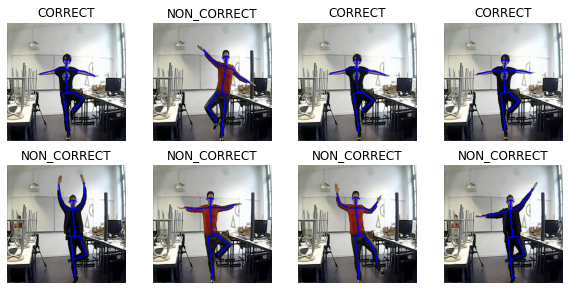

In [14]:
plt.figure(figsize=(10, 10))

for i in range(8):
    ax = plt.subplot(4, 4, i + 1)
    index = np.random.randint(0,len(dataset_entrainement))
    image = keras.utils.array_to_img(images_entrainement[index][0])
    image = np.array(image)
    draw_image = draw_lines(image, predictions_entrainement[index])
    plt.imshow(draw_image.astype("uint8"))
    plt.title(class_names[np.argmax(labels_entrainement[index], axis=None, out=None)])
    plt.axis("off")

# Création du modèle

Le modèle que nous allons utiliser va prendre en entrée les coordonnées des positions et proposer une classification en fonction de ces données.

Le format des données est le suivant:  
- predictions_entrainement[i] : (17,3)<br>
- labels_entrainement[i] : (1,2)<br>
        CORRECT : [1,0];  
        NON_CORRECT : [0,1]

In [15]:
# Fonction permettant de calculer le centre des hanches de la personne

# entrée : coordonneesXY (BS, 17,3)
# sortie : coordonnées du centre de la hanche [Y, X]
def Calcul_Centre_Hanches(coordonnees):
    hanche_gauche = tf.gather(coordonnees, 11, axis=1)
    hanche_droite = tf.gather(coordonnees, 12, axis=1)
    centre_hanches = 0.5*hanche_gauche + 0.5*hanche_droite
    return centre_hanches  # tenseur (BS,2) : [[Y,X]]

In [16]:
# Fonction permettant de calculer le centre des épaules de la personne

# entrée : coordonneesXY (BS, 17,3)
# sortie : coordonnées du centre des épaules [Y, X]
def Calcul_Centre_Epaules(coordonnees):
    epaule_gauche = tf.gather(coordonnees, 5, axis=1)
    epaule_droite = tf.gather(coordonnees, 6, axis=1)
    centre_epaules = 0.5*epaule_gauche + 0.5*epaule_droite
    return centre_epaules  # tenseur (BS, 2) : [[Y,X]]

In [17]:
# Fonction permettant de calculer la taille des coordonnées
# (l'étendue des coordonnées)

# entrée : Coordonnées (BS, 17,2)
# sortie : Maximum en entre :  taille du torse * coefficient_multiplicateur
#                           et distance maximale entre le centre et n'importe quelle coordonnées d'un point de la personne            
def Calcul_Taille_Coordonnees(coordonnees, facteur_multiplicateur_torse=2.5):
    # Récupère le centre des hanches
    centre_hanches = Calcul_Centre_Hanches(coordonnees)                    # (BS,2) : [[Y,X]]
    
    # Récupère le centre des épaules
    centre_epaules = Calcul_Centre_Epaules(coordonnees)                    # (BS,2) : [[Y,X]]

    # Taille du torse
    taille_torse = tf.linalg.norm(tf.expand_dims(centre_epaules-centre_hanches,1), axis=2)   # (BS,1)
   
    
    # Récupère le centre des hanches
    centre_hanches = Calcul_Centre_Hanches(coordonnees)                    # (BS,2) : [[Y,X]]
    
    # Création du tenseur pour décaler l'ensemble des coordonnées d'origines
    centre_hanches = tf.expand_dims(centre_hanches, axis=1)                                     # tenseur (BS, 1,2)
    centre_hanches = tf.broadcast_to(centre_hanches, [tf.size(coordonnees) // (13*2), 13, 2])   # tenseur (BS, 17,2)
    
    # Calcul des distances des différents points depuis le centre des hanches
    distances = coordonnees-centre_hanches                 # (BS, 17, 2)
    distances = tf.linalg.norm(distances, axis=2)          # (BS,17)
    
    # Récupère la distance maximale entre le centre des hanches et les points
    max_dist = tf.math.reduce_max(tf.expand_dims(distances,1), axis=2)            # (BS,1)

    # Retourne le maximum entre la distance maximale hanche <=> points
    # et taille du torse*facteur_multiplicatif
    return tf.math.maximum(taille_torse*facteur_multiplicateur_torse, max_dist)    

In [18]:
# Fonction permettant de calculer la taille des coordonnées
# (l'étendue des coordonnées)

# entrée : Coordonnées (BS, 17,2)
# sortie : Maximum en entre :  taille du torse * coefficient_multiplicateur
#                           et distance maximale entre le centre et n'importe quelle coordonnées d'un point de la personne            
def Calcul_Taille_Coordonnees2(coordonnees, facteur_multiplicateur_torse=2.5):
    # Récupère le centre des hanches
    centre_hanches = Calcul_Centre_Hanches(coordonnees)                    # (BS,2) : [[Y,X]]
    
    # Récupère le centre des épaules
    centre_epaules = Calcul_Centre_Epaules(coordonnees)                    # (BS,2) : [[Y,X]]

    # Taille du torse
    taille_torse = tf.linalg.norm(centre_epaules-centre_hanches) 
   
    # Récupère le centre des hanches
    centre_hanches = Calcul_Centre_Hanches(coordonnees)                    # (BS,2) : [[Y,X]]
    
    # Création du tenseur pour décaler l'ensemble des coordonnées d'origines
    centre_hanches = tf.expand_dims(centre_hanches, axis=1)                                     # tenseur (BS, 1,2)
    centre_hanches = tf.broadcast_to(centre_hanches, [tf.size(coordonnees) // (coordonnees.shape[1]*2), coordonnees.shape[1], 2])   # tenseur (BS, 17,2)
    
    # Calcul des distances des différents points depuis le centre des hanches
    d = tf.gather(coordonnees - centre_hanches, 0, axis=0, name="dist_to_pose_center")
    
    # Récupère la distance maximale entre le centre des hanches et les points
    max_dist = tf.reduce_max(tf.linalg.norm(d, axis=0))

    # Retourne le maximum entre la distance maximale hanche <=> points
    # et taille du torse*facteur_multiplicatif
    return tf.maximum(taille_torse * facteur_multiplicateur_torse, max_dist)

In [19]:
# Normalisation des données de position 
#  - en translatant le centre des hanches de la personne au coordonnées (0,0)
#  - en redimensionnant les coordonnées de sorte que la taille des coordonnées soit égale à 1

# Entrées :   coordonnees : (BS, 17,3)
def Normalisation_Positions(coordonnees):
    # Récupère le centre des hanches
    centre_hanches = Calcul_Centre_Hanches(coordonnees)                          # tenseur (BS,2) : [[Y,X]]
    
    # Création du tenseur pour décaler l'ensemble des coordonnées d'origines
    centre_hanches = tf.expand_dims(centre_hanches, axis=1)                                         # tenseur (BS,1,2)
    centre_hanches = tf.broadcast_to(centre_hanches, [tf.size(coordonnees) // (coordonnees.shape[1]*2), coordonnees.shape[1], 2])       # tenseur (BS,17,2)
    
    # Soustraction des coordonnées
    nouvelles_coordonnees = coordonnees - centre_hanches                  # (BS, 17,2)
    
    # Redimensionnement des coordonnées
    taille = Calcul_Taille_Coordonnees2(nouvelles_coordonnees)             # (BS)
    nouvelles_coordonnees = nouvelles_coordonnees / taille                # (BS,17,2)
    
    return nouvelles_coordonnees

In [20]:
# Traitement des entrées
#  - Translate le centre des hanches de la personne aux coordonnées (0,0)
#  - Normalise la position de sorte que sa taille soit égale à 1
#  - Applatissement du tenseur

# tenseur d'entrée : (BS,17,3)

def traitement_entrees(coordonnees_et_scores):
    # Normalisation des positions
    coordonnees = Normalisation_Positions(coordonnees_et_scores[:,:,:2])          # (BS,17,2)
    
    return coordonnees

In [21]:
# Définition du modèle
inputs_coordonnees = tf.keras.Input(shape=(17,3), name='input_1')
inputs_coeff = tf.keras.Input(shape=(4), name='input_2')

embedding = traitement_entrees(inputs_coordonnees)                          # (BS,17,2)

inputs_tete = embedding[:,0:5,:]        # (BS,5,2)
inputs_bras = embedding[:,5:11,:]       # (BS,6,2)
inputs_jambes = embedding[:,11:17,:]    # (BS,6,2)


layer_tete = keras.layers.Dense(128, activation=tf.nn.relu6)(keras.layers.Flatten()(inputs_tete))
layer_tete = keras.layers.Dropout(0.5)(layer_tete)
layer_tete = keras.layers.Dense(64, activation=tf.nn.relu6)(layer_tete)
layer_tete = keras.layers.Dropout(0.5)(layer_tete)
outputs_tete = keras.layers.Dense(2, activation="softmax")(layer_tete)

layer_bras = keras.layers.Dense(128, activation=tf.nn.relu6)(keras.layers.Flatten()(inputs_bras))
layer_bras = keras.layers.Dropout(0.5)(layer_bras)
layer_bras = keras.layers.Dense(64, activation=tf.nn.relu6)(layer_bras)
layer_bras = keras.layers.Dropout(0.5)(layer_bras)
outputs_bras = keras.layers.Dense(2, activation="softmax")(layer_bras)

layer_jambes = keras.layers.Dense(128, activation=tf.nn.relu6)(keras.layers.Flatten()(inputs_jambes))
layer_jambes = keras.layers.Dropout(0.5)(layer_jambes)
layer_jambes = keras.layers.Dense(64, activation=tf.nn.relu6)(layer_jambes)
layer_jambes = keras.layers.Dropout(0.5)(layer_jambes)
outputs_jambes = keras.layers.Dense(2, activation="softmax")(layer_jambes)

layer_global = keras.layers.Dense(128, activation=tf.nn.relu6)(keras.layers.Flatten()(embedding))
layer_global = keras.layers.Dropout(0.5)(layer_global)
layer_global = keras.layers.Dense(64, activation=tf.nn.relu6)(layer_global)
layer_global = keras.layers.Dropout(0.5)(layer_global)
outputs_global = keras.layers.Dense(2, activation="softmax")(layer_global)

outputs = inputs_coeff[:,0:1]*outputs_tete+inputs_coeff[:,1:2]*outputs_bras+inputs_coeff[:,2:3]*outputs_jambes+inputs_coeff[:,3:4]*outputs_global
outputs = keras.layers.Dense(2, activation="softmax")(outputs)

model = keras.Model([inputs_coordonnees,inputs_coeff], outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 17, 3)]      0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None, 17, 2)        0           input_1[0][0]                    
__________________________________________________________________________________________________
tf.compat.v1.gather (TFOpLambda (None, 2)            0           tf.__operators__.getitem[0][0]   
__________________________________________________________________________________________________
tf.compat.v1.gather_1 (TFOpLamb (None, 2)            0           tf.__operators__.getitem[0][0]   
______________________________________________________________________________________________

# Entrainement du modèle

In [22]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Nombre de périodes d'entrainement
periodes = 1000

# Définition de la fonction d'enregistrement automatique du meilleur modèle
model_save = ModelCheckpoint('meilleur_modele.hdf5', save_best_only=True, monitor='val_loss', mode='max')

# Définition de l'ooptimiseur
adam = keras.optimizers.Adam(learning_rate=1e-3)

# Entrainement du modèle : from_logits=True car on utilise un Softmax en sortie de notre modèle
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

historique = model.fit(x=[tf.convert_to_tensor(predictions_entrainement),
                          tf.transpose(tf.repeat(tf.convert_to_tensor([[1],[1],[1],[1]], dtype=tf.float32),repeats=[tf.convert_to_tensor(predictions_entrainement).shape[0]],axis=1))],
                       y=tf.squeeze(tf.convert_to_tensor(labels_entrainement),1),

                       validation_data=([tf.convert_to_tensor(predictions_validation),
                          tf.transpose(tf.repeat(tf.convert_to_tensor([[1],[1],[1],[1]], dtype=tf.float32),repeats=[tf.convert_to_tensor(predictions_validation).shape[0]],axis=1))],
                                       tf.squeeze(tf.convert_to_tensor(labels_validation),1)), \
                       verbose=1,epochs=periodes,
                       callbacks=[model_save])

Epoch 1/1000
2/2 [==============================] - 36s 7s/step - loss: 1.1279 - accuracy: 0.3469 - val_loss: 1.3293 - val_accuracy: 0.1667
Epoch 2/1000
2/2 [==============================] - 0s 121ms/step - loss: 1.0937 - accuracy: 0.3469 - val_loss: 1.2811 - val_accuracy: 0.1667
Epoch 3/1000
2/2 [==============================] - 0s 119ms/step - loss: 1.0670 - accuracy: 0.3469 - val_loss: 1.2323 - val_accuracy: 0.1667
Epoch 4/1000
2/2 [==============================] - 0s 118ms/step - loss: 1.0362 - accuracy: 0.3469 - val_loss: 1.1849 - val_accuracy: 0.1667
Epoch 5/1000
2/2 [==============================] - 0s 113ms/step - loss: 1.0073 - accuracy: 0.3469 - val_loss: 1.1383 - val_accuracy: 0.1667
Epoch 6/1000
2/2 [==============================] - 0s 111ms/step - loss: 0.9815 - accuracy: 0.3469 - val_loss: 1.0911 - val_accuracy: 0.1667
Epoch 7/1000
2/2 [==============================] - 0s 113ms/step - loss: 0.9437 - accuracy: 0.3469 - val_loss: 1.0430 - val_accuracy: 0.1667
Epoch 8/

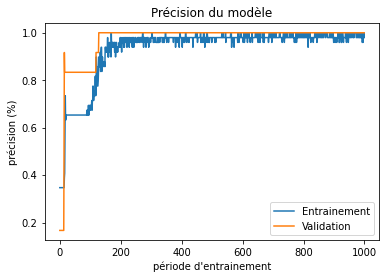

In [24]:
# Affichage de la progression de l'entrainement

plt.plot(historique.history['accuracy'])
plt.plot(historique.history['val_accuracy'])
plt.title('Précision du modèle')
plt.ylabel('précision (%)')
plt.xlabel("période d'entrainement")
plt.legend(['Entrainement', 'Validation'], loc='lower right')
plt.show()

# Tests du modèle sur les données de validation

labels_validation[index]Les probabilités du label CORRECT sont affichées entre crochets :

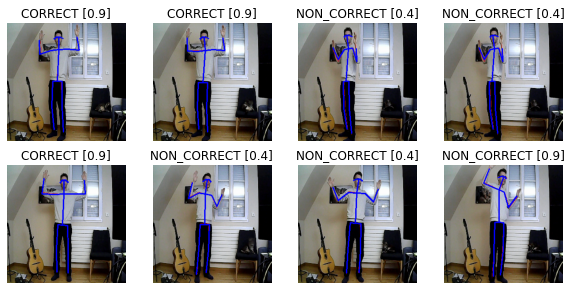

In [51]:
plt.figure(figsize=(10, 10))

for i in range(8):
    ax = plt.subplot(4, 4, i + 1)
    index = np.random.randint(0,len(dataset_validation))
    image = keras.utils.array_to_img(images_validation[index][0])
    image = np.array(image)
    draw_image = draw_lines(image, predictions_validation[index])
    
    pred = model([tf.expand_dims(tf.convert_to_tensor(predictions_validation)[index],0),
                 tf.convert_to_tensor([[1.0,1.0,1.0,1.0]], dtype=tf.float32)])
    
    plt.imshow(draw_image.astype("uint8"))
    plt.title(class_names[np.argmax(labels_validation[index], axis=None, out=None)]+" [%.1f]" %(pred.numpy()[0][0]))
    plt.axis("off")

# Sauvegarde du modèle

In [ ]:
!mkdir "SaveModel2"

In [ ]:
tf.saved_model.save(model,"/home/jetson/notebook/Olympiades2024/3. Model_Classification/SaveModel2")